# Lagged cross-covariance analysis

Resolution: TransCom 3 regions, daily

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [4]:
# Compute the daily mean in each Transcom region
DS_tc = utils.read_transcom("../data/exp_pro/TRANSCOM_region_mask.nc")

df_sif_tc = (
    utils.map_transcom(DS_sif, DS_tc)
    .groupby(["region"])
    .resample("1D")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)
df_xco2_tc = (
    utils.map_transcom(DS_xco2, DS_tc)
    .groupby(["region"])
    .resample("1D")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)

# Merge dataframes
df_tc_daily = pd.merge(df_sif_tc, df_xco2_tc, on=["region", "time"], how="outer")
df_tc_daily

,region,time,sif,xco2
0,1.0,2014-09-06,0.072970,390.859924
1,1.0,2014-09-07,0.031946,391.796814
2,1.0,2014-09-08,0.129070,391.608002
3,1.0,2014-09-09,0.067277,393.902344
4,1.0,2014-09-10,0.114069,391.003326
...,...,...,...,...
23711,11.0,2020-07-27,0.515968,408.723907
23712,11.0,2020-07-28,0.440658,406.307312
23713,11.0,2020-07-29,0.380930,408.973145
23714,11.0,2020-07-30,0.394800,408.789551


In [5]:
# Groupby region and compute cross-correlation
df_stats = (
    df_tc_daily
    .drop(columns=["time"])
    .groupby(["region"])
    .apply(lambda group: stats.get_stats_df(group, lags=[30, 60], tau=30))
    .reset_index()
    .drop(columns=["level_1"])
 )

df_stats

,region,sif_count,xco2_count,sif_slope,xco2_slope,sif_std,xco2_std,xcor_lag30,xcor_lag60
0,1.0,1619,1340,3.656261e-06,0.007369,0.077534,3.596584,-0.640767,-0.444677
1,2.0,1957,1954,2.132114e-05,0.007145,0.165118,2.203781,-0.623243,-0.735774
2,3.0,1957,1935,4.761198e-07,0.006908,0.052281,1.359730,-0.171060,-0.096244
3,4.0,1957,1946,1.131652e-05,0.006738,0.131674,0.925300,-0.070986,-0.022754
4,5.0,1971,1970,4.141589e-06,0.007127,0.044308,1.922010,-0.594403,-0.598354
5,6.0,1965,1949,6.310131e-06,0.006707,0.121278,1.105337,-0.549497,-0.396349
6,7.0,1760,1681,2.084789e-05,0.007021,0.131202,3.494946,-0.749552,-0.507554
7,8.0,1971,1970,1.160786e-05,0.007101,0.057506,2.228759,-0.561333,-0.599308
8,9.0,1968,1905,1.632595e-05,0.007076,0.103115,1.732510,-0.395974,-0.444580
9,10.0,1953,1951,-7.704524e-06,0.006869,0.064261,0.625812,-0.145311,-0.035679


In [6]:
# Map values to transcom grid dataset
df_regions = DS_tc.to_dataframe().dropna().reset_index()
DS_regions = (
    df_regions
    .merge(df_stats, on=["region"])
    .set_index(["lon", "lat"])
    .to_xarray()
   )

DS_regions

<xarray.Dataset>
Dimensions:     (lat: 137, lon: 338)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -54.5 -53.5 -52.5 -51.5 ... 78.5 79.5 80.5 82.5
Data variables:
    region      (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    sif_count   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xco2_count  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_slope   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xco2_slope  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_std     (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xco2_std    (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag30  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag60  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))


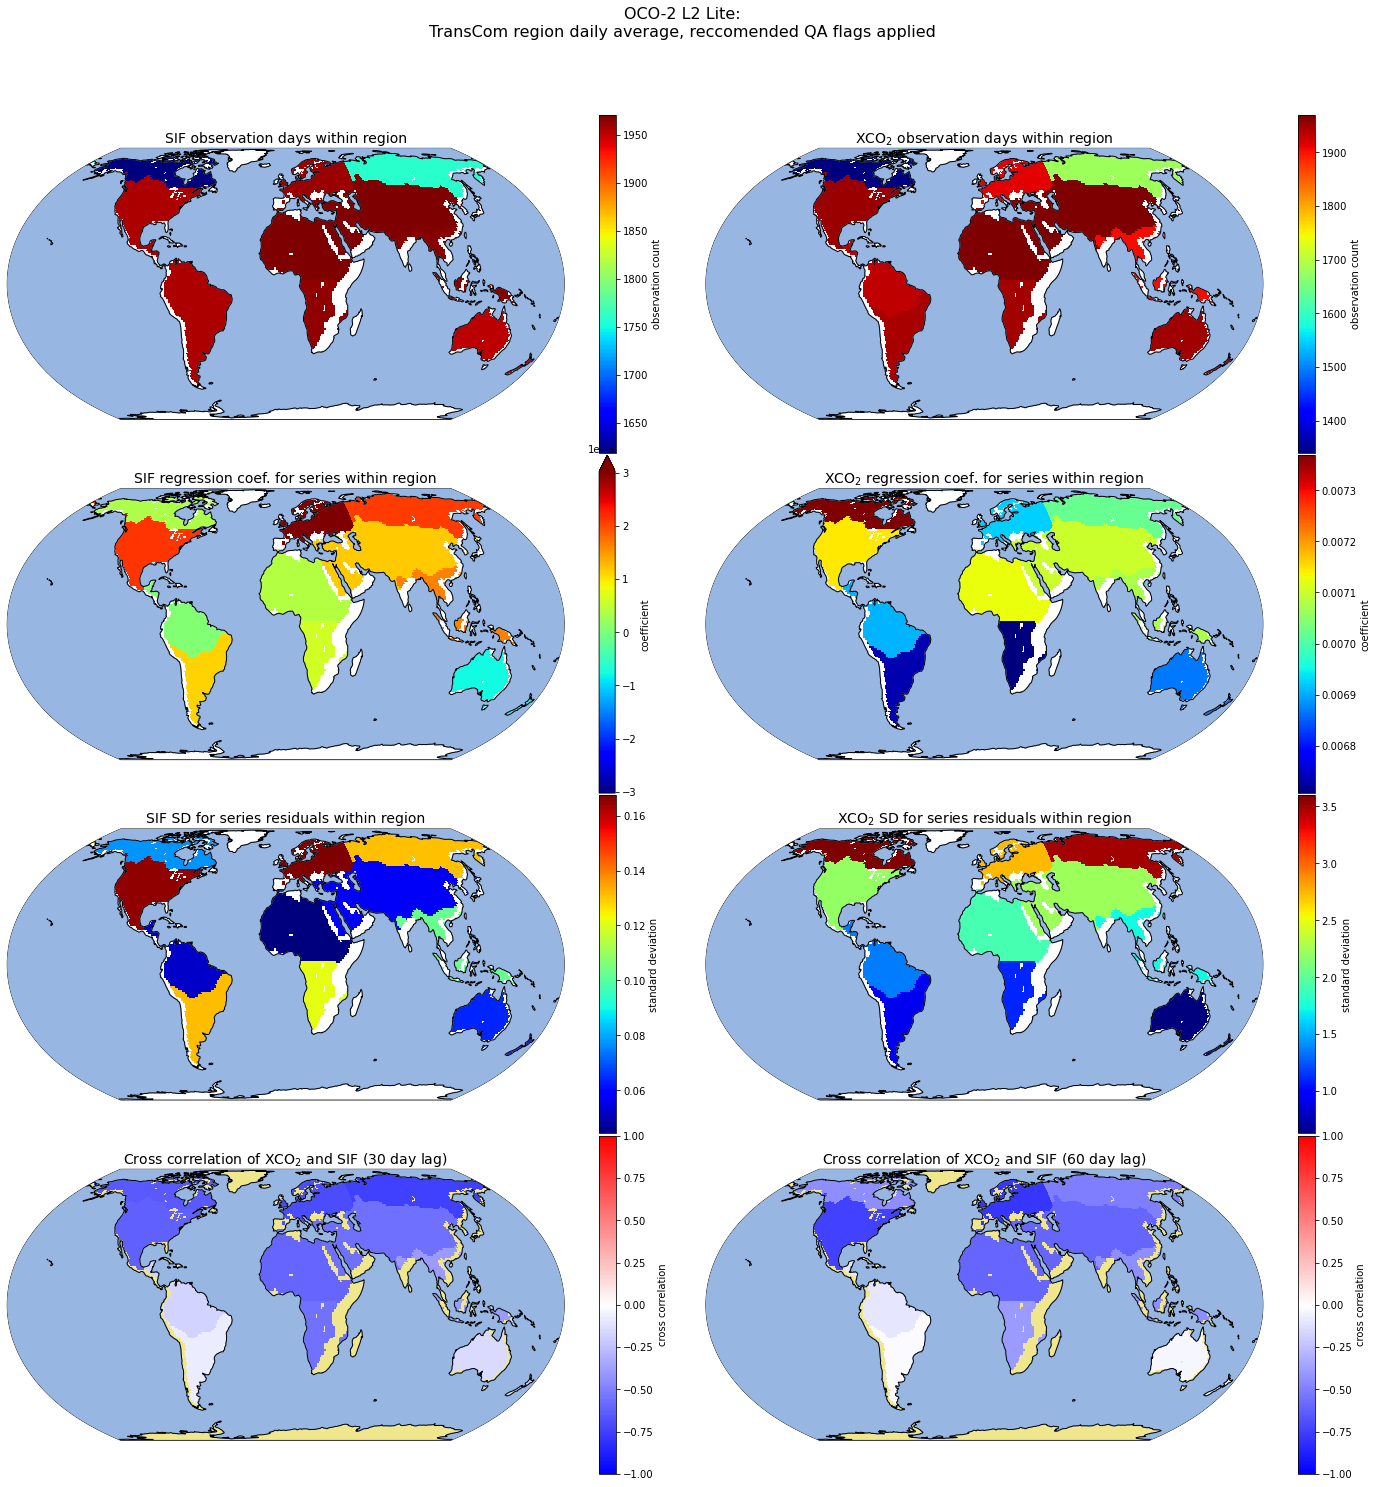

In [7]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "TransCom region daily average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_count,
    title="SIF observation days within region",
    ax=ax1,
    cbar_kwargs={"label": "observation count"}
)
plot.plot_da(
    DS_regions.xco2_count,
    title="XCO$_2$ observation days within region",
    ax=ax2,
    cbar_kwargs={"label": "observation count"}
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_slope,
    title="SIF regression coef. for series within region",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_regions.xco2_slope,
    title="XCO$_2$ regression coef. for series within region",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_std,
    title="SIF SD for series residuals within region",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_regions.xco2_std,
    title="XCO$_2$ SD for series residuals within region",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Define color map with nans set to khaki
cmap = plt.get_cmap("bwr")
cmap.set_bad("khaki")

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.xcor_lag30,
    title="Cross correlation of XCO$_2$ and SIF (30 day lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_regions.xcor_lag60,
    title="Cross correlation of XCO$_2$ and SIF (60 day lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/transcom_daily_panel.png");